<a href="https://colab.research.google.com/github/sagar-ML-Developer/Machine-Learning-projects/blob/master/from_exploration_to_linear_regression_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to the problem - **Prediction of each trip duration.** 

The data was originally published by the NYC Taxi and Limousine Commission (TLC).

This notebook is made with reference to [this notebook](https://www.kaggle.com/ashishc17/from-exploration-to-linear-regression-prediction)

In [1]:
# Here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
import datetime as dt
plt.style.use('ggplot')

Find the dataset [here](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)
For easier access to data, follow the steps:


1.   Unzip the data folder on local computer, after downloading data from above link, you should see train csv and test csv among other files.
2.   Make a *data* folder on your Google drive, and upload these files to that folder.
3. If you choose to save file at any other location, mention that paths in path command below.



In [9]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [10]:
train_data_path = "/content/drive/My Drive/data/train.csv"
test_data_path = "/content/drive/My Drive/data/test.csv"

In [11]:
train=pd.read_csv(train_data_path,infer_datetime_format=True,parse_dates=[2,3])
test=pd.read_csv(test_data_path,infer_datetime_format=True,parse_dates=[2,3])

**1. Introduction to the dataset**

Revealing the basic info about the train dataset and optimizing dtypes of variables to reduce memory usage.

In [12]:
#Checking the 1ast 5 rows as to how data looks.

print(train.shape)
train.head()

(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
print(test.shape)
test.head()

(625134, 9)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [14]:
print(train.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


In [15]:
#Checking the dtypes and missing values(if any)
print(train.info())

#Optimizing dtypes for the reduction of memory
train.passenger_count=train.passenger_count.astype(np.int8)
train.vendor_id=train.vendor_id.astype(np.int8)
train.trip_duration=train.trip_duration.astype(np.int32)
for c in [c for c in train.columns if c.endswith('tude')]:
    train.loc[:,c]=train[c].astype(np.float32)
    
#Checking memory usage 
print('Memory usage,Mb: {:.2f}\n'.format(train.memory_usage().sum()/2**20)) #Nearly 50% memory has been reduced.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
None
Memory usage,Mb: 75.12





No null entries .
After reducing their dtypes, memory usage has reduced by 50%.

In [16]:
#Checking the range and statistical distribution of the variables.
train.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-72.7866,40.2487,-72.7863,40.2489,959.492
std,0.498777,1.31424,1.18915,0.503276,1.18926,0.504102,5237.43
min,1,0,-121.933,34.3597,-121.933,32.1811,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06


Staring with the coordinates . **NYC coodinates : 40.730610, -73.935242**
There are huge outliers in the coordinates.
Even the trip duration range is **1sec to 3526282sec**. Needless to say, any trip cannot last for a sec or apprx 980 hrs.

In [17]:
test.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134,625134,625134,625134,625134
mean,1.53488,-73.9736,40.7509,-73.9735,40.7518
std,0.498782,0.073389,0.0298478,0.0725649,0.0358239
min,1,-121.933,37.3896,-121.933,36.6013
25%,1,-73.9919,40.7374,-73.9913,40.736
50%,2,-73.9817,40.7541,-73.9798,40.7545
75%,2,-73.9674,40.7684,-73.963,40.7699
max,2,-69.2489,42.8149,-67.4968,48.8576


Same with the test dataset as some of the trips were outstation ones. 
We need to clean this dataset as well.

#**2. Data Cleaning**

First, we will corect the coordinates range to work with. 
Range of *latitude coordinates* : **40.6 to 40.9**
Range of *longitude coordinates* : **-74.25 to -73.7**

After cross checking with the google maps and finding the location of the extreme coordinates range, it is highly unlikely that any trip would last for more than 120 min or less than 5min.
Trip duration range : **5min to 120 min**

For the coordinates filtering, we will be filtering using the same coordinates range on the train and test datset.



In [18]:
# Setting Coordinates range 
lat_min=40.6
lat_max=40.9
long_min=-74.25
long_max=-73.7

#Defining coordinates range
def lat_range(lati):
    return lati>=lat_min and lati<=lat_max
def long_range(longi):
    return longi>=long_min and longi<=long_max

#Fixing the coordinates range
train=train[(train['pickup_latitude'].apply(lat_range)) & (train['pickup_longitude'].apply(long_range))]
train=train[(train['dropoff_latitude'].apply(lat_range)) & (train['dropoff_longitude'].apply(long_range))]

test=test[(train['pickup_latitude'].apply(lat_range)) & (test['pickup_longitude'].apply(long_range))]
test=test[(test['dropoff_latitude'].apply(lat_range)) & (test['dropoff_longitude'].apply(long_range))]

#Correcting the trip range as we are concerend with only the trips within NYC.
train=train[(train.trip_duration>300)&(train.trip_duration<3600)]

print(train.shape[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1222126


In [19]:
#Checking the range
print('Latitude Range:{} to {}'.format(max(train.pickup_latitude.min(),train.dropoff_latitude.min()),max(train.pickup_latitude.max(),train.dropoff_latitude.max())))
print('Longitude Range:{} to {}'.format(max(train.pickup_longitude.min(),train.dropoff_longitude.min()),max(train.pickup_longitude.max(),train.dropoff_longitude.max())))
print('Trip duration in sec range:{} to {}'.format(train.trip_duration.min(),train.trip_duration.max()))
print('Datetime range:{} to {}'.format(train.pickup_datetime.min(),train.dropoff_datetime.max()))
print('Passenger range: {} to {}'.format(train.passenger_count.min(),train.passenger_count.max()))

Latitude Range:40.600677490234375 to 40.89995574951172
Longitude Range:-74.22979736328125 to -73.70030212402344
Trip duration in sec range:301 to 3599
Datetime range:2016-01-01 00:00:17 to 2016-07-01 00:48:20
Passenger range: 0 to 9


As any trip would be counted if passenger were to be sitting in a car. Hence, we will find out the empty trips and would drop those entries without any passenger.

In [20]:
train=train[train.passenger_count>0]
print('Passenger range: {} to {}'.format(train.passenger_count.min(),train.passenger_count.max()))
print(train.shape[0])
# In total 12 entries were without any passenger.

Passenger range: 1 to 9
1222114


#**3.Visualization Analysis**



As visualization gives the meaningful insights to explore the data.

We will be using **histogram** to understand the distribution of the dataset.

**Barplot** to count the no of entries using different analysing methods.

**Lineplot** to compare.

**Heatmap** to extract insights using relative density.

**Scatter plot** for mapping the coordinates on the NYC map to extract pick up and drop off locations.

For the analysis at different level, we are grouping the pickup and datetime at hourly, daily and monthly basis.

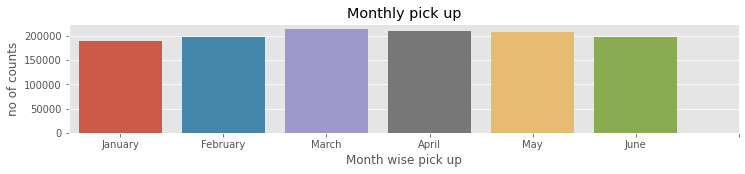

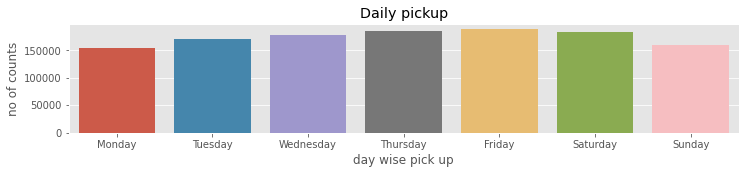

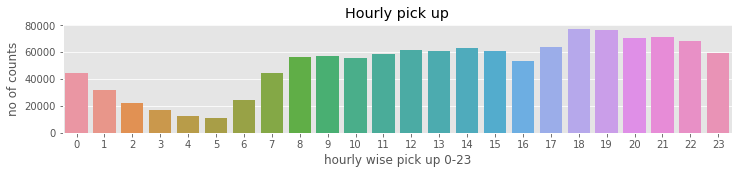

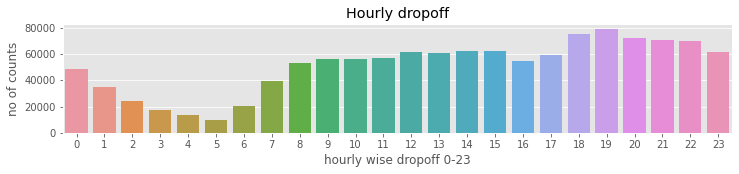

<Figure size 864x720 with 0 Axes>

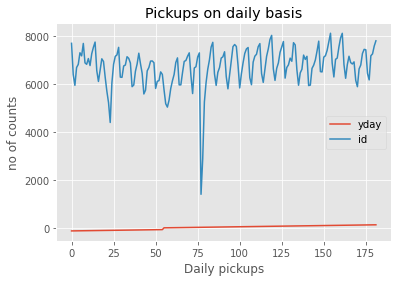

In [21]:
#Naming week of a day and month of a year
dow_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mm_names=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#Grouping month wise
train['mm_pickup']=train.pickup_datetime.dt.month.astype(np.int8)
train['mm_dropoff']=train.dropoff_datetime.dt.month.astype(np.int8)

test['mm_pickup']=test.pickup_datetime.dt.month.astype(np.int8)

#Grouping day wise
train['dow_pickup']=train.pickup_datetime.dt.weekday.astype(np.int8)
train['dow_dropoff']=train.dropoff_datetime.dt.weekday.astype(np.int8)

test['dow_pickup']=test.pickup_datetime.dt.weekday.astype(np.int8)

#Grouping day of year wise
train['yday']=train.pickup_datetime.dt.dayofyear.astype(np.int8)
test['yday']=test.pickup_datetime.dt.dayofyear.astype(np.int8)

#Grouping hour wise
train['hh_pickup']=train.pickup_datetime.dt.hour.astype(np.int8)
train['hh_dropoff']=train.dropoff_datetime.dt.hour.astype(np.int8)

test['hh_pickup']=test.pickup_datetime.dt.hour.astype(np.int8)

#Plotting pickup wise
#Monthly
plt.figure(figsize=(12,2))
month_wise=train.groupby('mm_pickup').agg({'id':'count'}).reset_index()
sns.barplot(x='mm_pickup',y='id',data=month_wise)
plt.xlabel('Month wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),mm_names[:6])
plt.title('Monthly pick up')
pass

#Day of a week
plt.figure(figsize=(12,2))
day_wise=train.groupby('dow_pickup').agg({'id':'count'}).reset_index()
sns.barplot(x='dow_pickup',y='id',data=day_wise)
plt.xlabel('day wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),dow_names)
plt.title('Daily pickup')
pass

#Hourly
plt.figure(figsize=(12,2))
hour_wise=train.groupby('hh_pickup').agg({'id':'count'}).reset_index()
sns.barplot(x='hh_pickup',y='id',data=hour_wise)
plt.xlabel('hourly wise pick up 0-23')
plt.ylabel('no of counts')
plt.title('Hourly pick up')
pass


#Hourly dropoff
plt.figure(figsize=(12,2))
hhdrop_wise=train.groupby('hh_dropoff').agg({'id':'count'}).reset_index()
sns.barplot(x='hh_dropoff',y='id',data=hhdrop_wise)
plt.xlabel('hourly wise dropoff 0-23')
plt.ylabel('no of counts')
plt.title('Hourly dropoff')
pass

#Daily dropoff
plt.figure(figsize=(12,10))
yday_wise=train.groupby('yday').agg({'id':'count'}).reset_index()
yday_wise.plot(kind='line')
plt.xlabel('Daily pickups')
plt.ylabel('no of counts')
plt.title('Pickups on daily basis')
pass

In the starting 2 months, trips were slightly on a lower side(may be due to extreme cold weather). 


It also can be seen from the 1st graph that trips started decreasing after the month of March.


Maximum daily pickups usually noticed on Thursday, Friday and Saturday.


In the early morning time, as usual less traffic.
Max rush was at 6 to 7pm followed by 8 to 10pm.


From the last graph(line), there was a sudden dip in trips in the middle of March. 

We will be using weather data to check for the further insights on a sudden dip in trips.

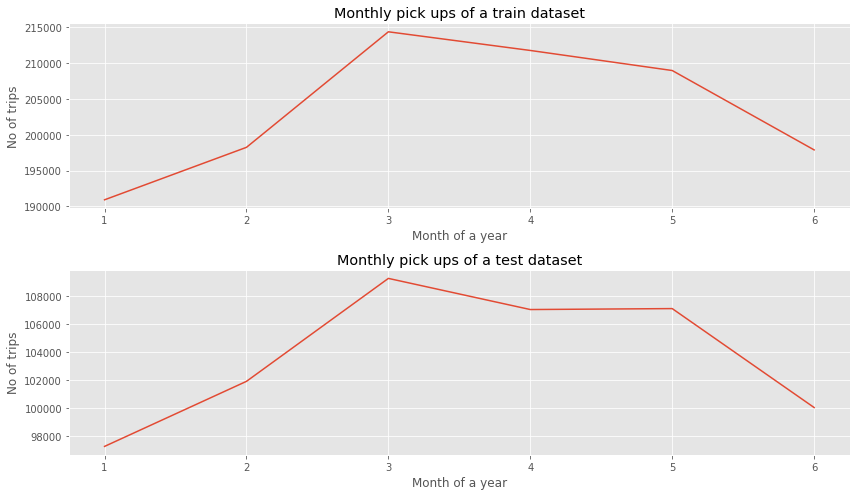

In [22]:
#Checking the pickups on a daily basis comparing train and test dataset
fig, ax= plt.subplots(nrows=2,ncols=1,figsize=(12,7))
plt.subplot(211)
trips_train=train.groupby('mm_pickup').agg({'id':'count'})
plt.plot(trips_train)
plt.title('Monthly pick ups of a train dataset')
plt.xlabel('Month of a year')
plt.ylabel('No of trips')
pass

plt.subplot(212)
trips_test=test.groupby('mm_pickup').agg({'id':'count'})
plt.plot(trips_test)
plt.title('Monthly pick ups of a test dataset')
plt.xlabel('Month of a year')
plt.ylabel('No of trips')
pass

fig.tight_layout()

Same type of trip distribution in train and test dataset except in the 4th month where a lil bit dip is seen in the month of April

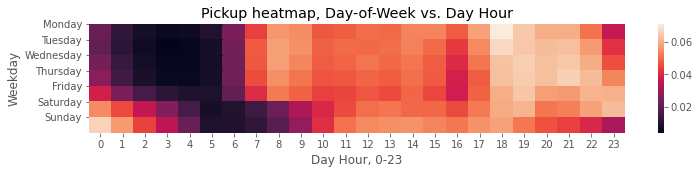

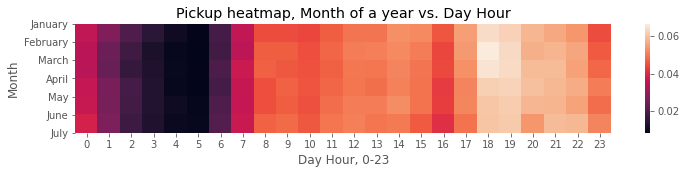

In [23]:
#heatmap hour vs day wise
plt.figure(figsize=(12,2))
plot1=pd.crosstab(train.dow_pickup,train.hh_pickup,values=train.vendor_id,aggfunc='count',normalize='index')
sns.heatmap(plot1)
plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday')
plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7),dow_names,rotation='horizontal') 
pass

#heatmap hour vs month wise
plt.figure(figsize=(12,2))
plot2=pd.crosstab(train.mm_pickup,train.hh_pickup,values=train.vendor_id,aggfunc='count',normalize='index')
sns.heatmap(plot2)
plt.title('Pickup heatmap, Month of a year vs. Day Hour')
plt.ylabel('Month')
plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7),mm_names,rotation='horizontal')
pass

From the 1st heatmap,it can be seen  that max rush noticed on ending days of a week at time around 6 pm to 10 pm.

Same pattern though traffic in the month of May and June is greater as compared to other months in the same time frame.

*Trip Duration Analysis*

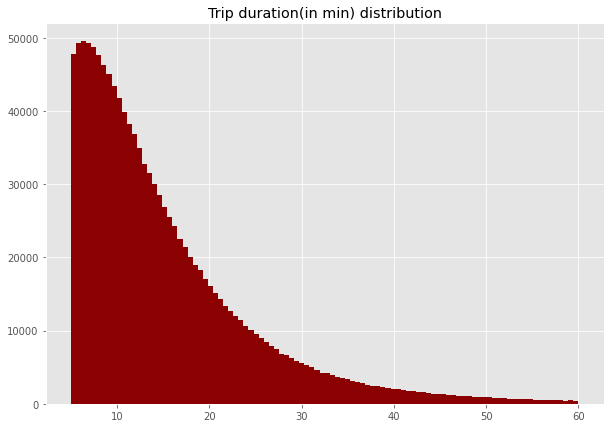

In [24]:
#Plotting Histogram 
plt.figure(figsize=(10,7))
plt.hist(train.trip_duration/60,bins=100,color='darkred')
plt.title('Trip duration(in min) distribution')
pass

Most of the trips last for less than 10-20 minutes and barely few could cross a span of 50-60 min.


People travel shorter distances in short time duration

No of trips that lasted for the max duration was noticed on Thursday,Friday and Saturday betwen 8 AM to 5 PM and if we go by Month vs Hour distribution then in the starting months of 2016 larger trip duration lasted during 2 to 5 PM.


Analyzing trips with respect to **Vendor**

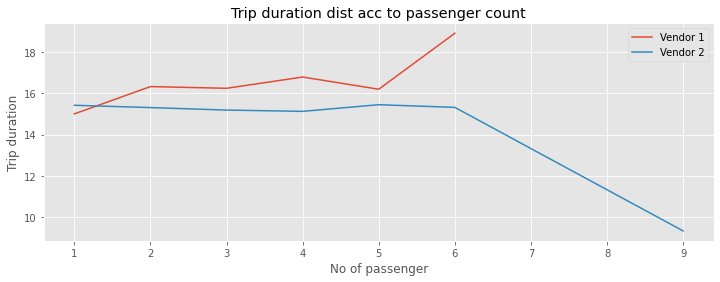

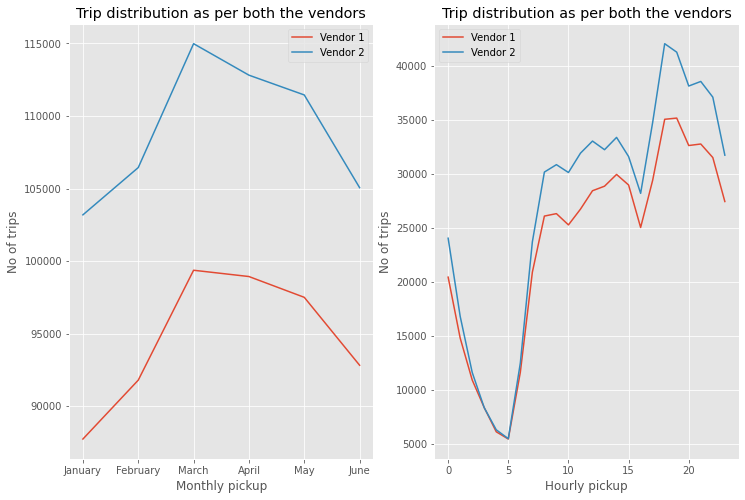

In [25]:
#No of trips acc to passenger count
plt.figure(figsize=(12,4))
table=pd.crosstab(index=train.passenger_count ,columns=train.vendor_id ,values=train.trip_duration/60, aggfunc='mean')
plt.plot(table)
plt.legend(['Vendor 1','Vendor 2'])
plt.xlabel('No of passenger')
plt.ylabel('Trip duration')
plt.title('Trip duration dist acc to passenger count')
pass

plt.subplots(nrows=1,ncols=2,figsize=(12,8))

#No of trips on the basis of Month wrt Vendor using vendor id
plt.subplot(121)
data = pd.crosstab(index=train.mm_pickup,columns=train.vendor_id,values=train.id,aggfunc='count')
plt.title('Trip distribution as per both the vendors')
plt.xlabel('Monthly pickup')
plt.ylabel('No of trips')
plt.xticks(range(1,7),mm_names)
plt.plot(data)
plt.legend(['Vendor 1','Vendor 2'])
pass

#No of trips on the basis of Month wrt Vendor
plt.subplot(122)
data1 = pd.crosstab(index=train.hh_pickup,columns=train.vendor_id,values=train.id,aggfunc='count')
plt.title('Trip distribution as per both the vendors')
plt.xlabel('Hourly pickup')
plt.ylabel('No of trips')
plt.plot(data1)
plt.legend(['Vendor 1','Vendor 2'])
pass

Trips taken by Vendor 1 lasted for greater trip duration as compared to Vendor2. 

But, Vendor 2 took greater trips(from the 2nd left graph) as compared to the other vendor and with varying passenger count as well.


At the early hours, both the vendors took the same no of trips. But after 7 or 8 AM, Vendor 2 took larger trips as compared to Vendor 1.

*Checking trips wrt storing or not storing the trip and then forwarding*

N    1215322
Y       6792
Name: store_and_fwd_flag, dtype: int64


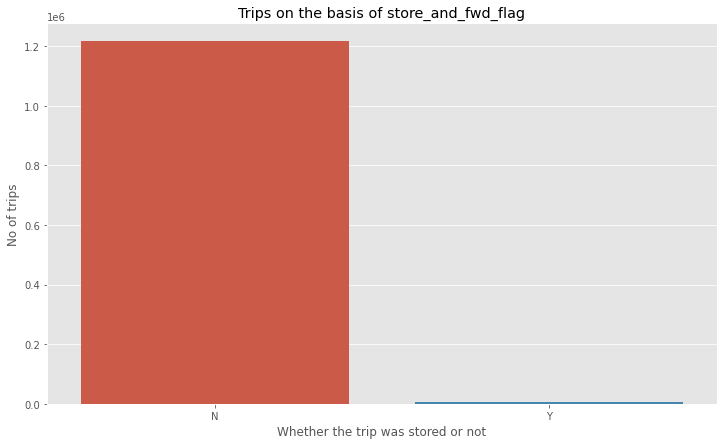

In [26]:
plt.figure(figsize=(12,7))

store=train.groupby('store_and_fwd_flag').agg({'id':'count'}).reset_index()
sns.barplot(x='store_and_fwd_flag',y='id',data=store)
plt.xlabel('Whether the trip was stored or not')
plt.ylabel('No of trips')
plt.title('Trips on the basis of store_and_fwd_flag')
pass

print(train['store_and_fwd_flag'].value_counts())


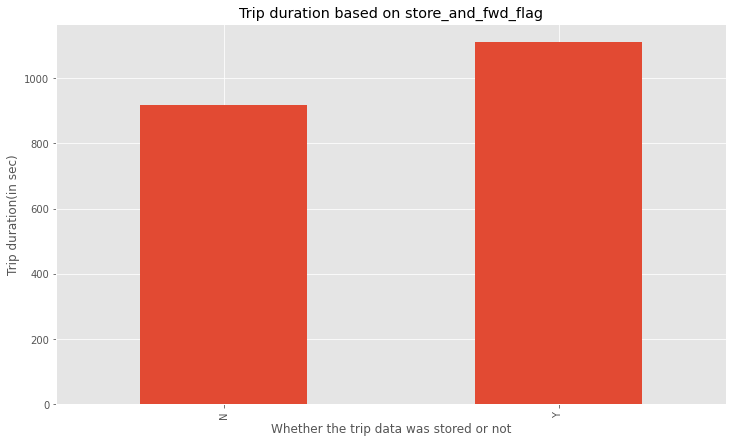

In [27]:
plt.figure(figsize=(12,7))
store=train.groupby('store_and_fwd_flag')['trip_duration'].mean()
store.plot(kind='bar',x='store_and_fwd_flag',y='trip_duration')
plt.xlabel('Whether the trip data was stored or not')
plt.ylabel('Trip duration(in sec)')
plt.title('Trip duration based on store_and_fwd_flag')
pass

<Figure size 1368x1080 with 0 Axes>

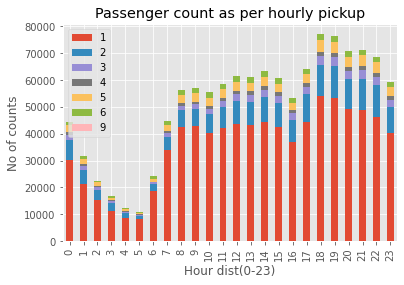

In [28]:
#Passenger count as per hourly pickup
plt.figure(figsize=(19,15))
hourly_passenger=train.groupby(['hh_pickup','passenger_count']).size().unstack()
hourly_passenger.plot(kind='bar',stacked=True,legend=False)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('No of counts')
plt.title('Passenger count as per hourly pickup')
plt.legend(loc="upper left")
pass

#Clearly visible in the graph pattern distribution on hourly basis according to passenger count.

Based on the above visualization plots, maximum no of trips were reported as "N" in storing the data and the mean trip duration was higher on those trips where trip data was stored.

Now for further deep analysis, we need to create a couple of columns:

*Column 1* - **Distance**

*Column 2* - **Speed**

We are creating a new column : Distance using **Haversine** formula which takes into consideration of latitude and longitude coordinates.

By far, Haversine formula is the most widely formula used

As the coordinates are concentrated tightly on the poles than on the Equator.
We are taking Earth's radius to be **6371** which is greater than at the poles.

As the Earth is not a perfect sphere, there will be few discrepencies in calculating distance using this formula

In [29]:
#Haversine formula to calculate distance using longitude and latitude coordinates, for train dataset
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371*1.1 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

#Iterating over each row of the 4 columns
dist=[]
for i,row in train.iterrows():
    x=distance((train.pickup_latitude[i],train.pickup_longitude[i]),(train.dropoff_latitude[i],train.dropoff_longitude[i]))
    dist.append(x)


#Naming it as a new column
train['distance_km']=dist

In [30]:
#Haversine formula to calculate distance using longitude and latitude coordinates, applying the same for test dataset
#Iterating over each row of the 4 columns
dist_test=[]
for i,row in test.iterrows():
    x=distance((test.pickup_latitude[i],test.pickup_longitude[i]),(test.dropoff_latitude[i],test.dropoff_longitude[i]))
    dist_test.append(x)


#Naming it as a new column
test['distance_km']=dist_test

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Trips in distance using log transformation')

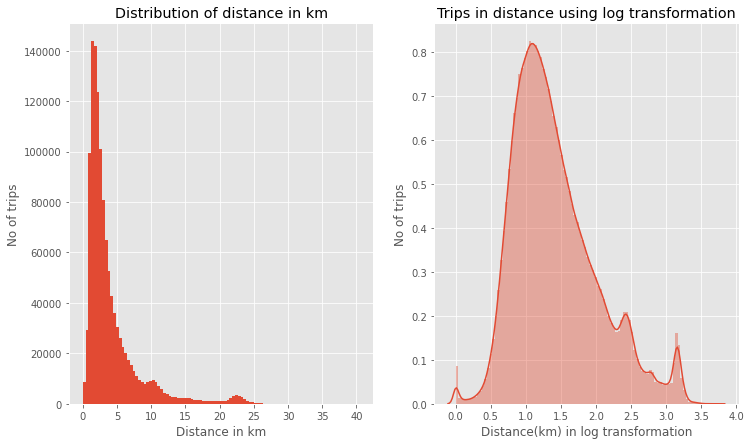

In [31]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(train['distance_km'],bins=100)
plt.xlabel('Distance in km')
plt.ylabel('No of trips')
plt.title('Distribution of distance in km')
pass

#Plotting histogram with a log transformation
plt.subplot(122)
train['log_distance']=np.log(train['distance_km'].values + 1)
sns.distplot(train['log_distance'].values,bins=100)
plt.xlabel('Distance(km) in log transformation')
plt.ylabel('No of trips')
plt.title('Trips in distance using log transformation')

#Max trips lasted for shorter distances

Now analyzing distribution of distance travelled across days, hours and month of a year along with the passenger count.

Majority of the distance are shorter in km.

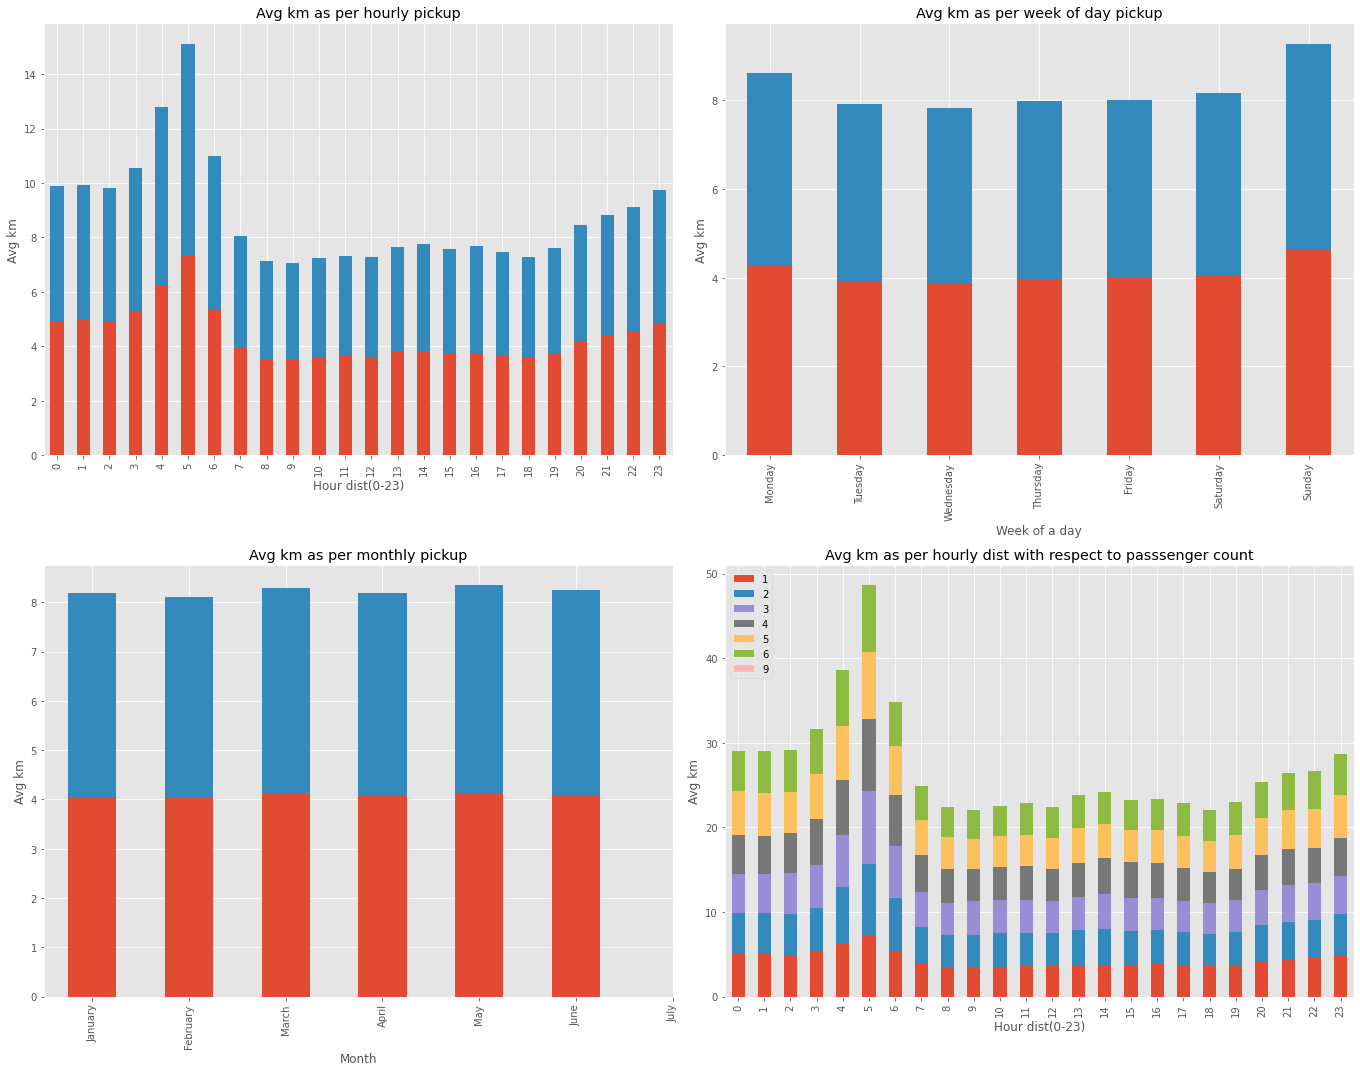

In [32]:
#Mean distance over different analysis
data1=train.groupby(['hh_pickup','vendor_id'])['distance_km'].mean().unstack()
data2=train.groupby(['dow_pickup','vendor_id'])['distance_km'].mean().unstack()
data3=train.groupby(['mm_pickup','vendor_id'])['distance_km'].mean().unstack()
data4=train.groupby(['hh_pickup','passenger_count'])['distance_km'].mean().unstack()

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(19, 15))

#Avg km as per hourly pickup
figure=plt.subplot(2,2,1)
data1.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('Avg km')
plt.title('Avg km as per hourly pickup')
pass

#Avg km as per week of day pickup
figure=plt.subplot(2,2,2)
data2.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Week of a day')
plt.ylabel('Avg km')
plt.title('Avg km as per week of day pickup')
plt.xticks(range(0,7),dow_names)
pass

#Avg km as per monthyly pickup
figure=plt.subplot(2,2,3)
data3.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Month')
plt.ylabel('Avg km')
plt.title('Avg km as per monthly pickup')
plt.xticks(range(0,7),mm_names)
pass

figure=plt.subplot(2,2,4)
data4.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('Avg km')
plt.title('Avg km as per hourly dist with respect to passsenger count')
plt.legend(loc = "upper left")
pass

fig.tight_layout()

In the early morning hours, there is a rise in km travelled. People used to prefer going other places in the early hours to avoid rush. 

In the 2nd barplot, there is a rise in km travelled on Sunday, followed by Monday. People usually go or come from other places on a Sunday and Monday early hours.

*Creation of an another column* : **Speed**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Speed using log transformation')

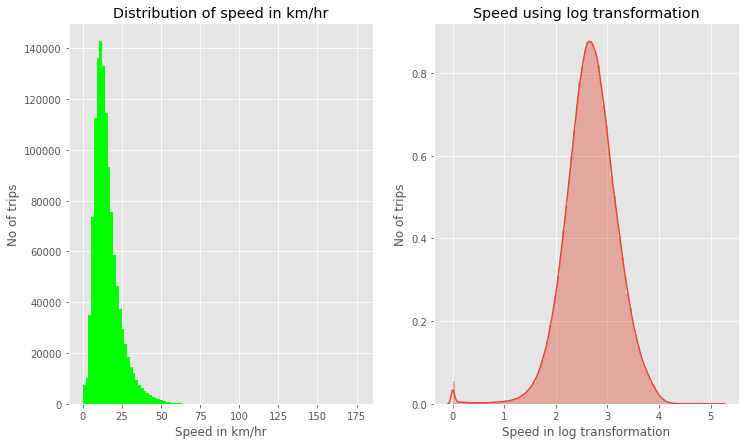

In [33]:
#Speed in km/hr
train['speed']=train.distance_km/(train.trip_duration/3600)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(train['speed'],bins=100,color='lime')
plt.xlabel('Speed in km/hr')
plt.ylabel('No of trips')
plt.title('Distribution of speed in km/hr')
pass

plt.subplot(122)
train['log_speed']=np.log(train['speed'].values + 1)
sns.distplot(train['log_speed'].values,bins=100)
plt.xlabel('Speed in log transformation')
plt.ylabel('No of trips')
plt.title('Speed using log transformation')

As the distance travelled and trip duration are very low. So is the case with the average speed over trips.

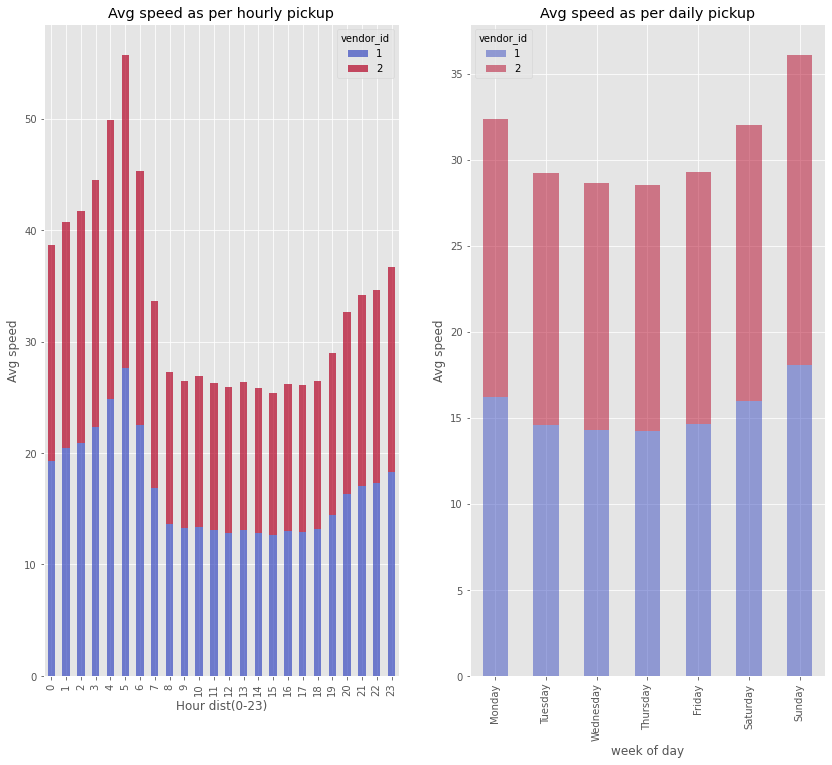

In [34]:
#Analyzing average speed over different parameters

data1=train.groupby(['hh_pickup','vendor_id'])['speed'].mean().unstack()
data2=train.groupby(['dow_pickup','vendor_id'])['speed'].mean().unstack()

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(14, 12))

figure=plt.subplot(121)
data1.plot(kind='bar',stacked=True,alpha=0.7,colormap='coolwarm',ax=figure)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('Avg speed')
plt.title('Avg speed as per hourly pickup')
pass

#Avg speed as per week of day
figure=plt.subplot(122)
data2.plot(kind='bar',stacked=True,alpha=0.5,colormap='coolwarm',ax=figure)
plt.xlabel('week of day')
plt.ylabel('Avg speed')
plt.title('Avg speed as per daily pickup')
plt.xticks(range(0,7),dow_names)
pass

From the above graphs, it is not that people prefer travelling more on Sunday and Monday. Due to fewer no of pickups in early morning hours, average speed also rises.

How our **train and test datset top 5 entries** look like after creating few new columns

In [35]:
#Dropping log_speed column
train=train.drop('log_speed',axis=1)

In [36]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,mm_pickup,mm_dropoff,dow_pickup,dow_dropoff,yday,hh_pickup,hh_dropoff,distance_km,log_distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,0,0,74,17,17,1.648373,0.973945,13.042071
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,6,6,-92,0,0,1.986058,1.093954,10.784025
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,1,1,19,11,12,7.023608,2.082388,11.904421
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,2,2,97,19,19,1.634048,0.968522,13.712293
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,5,5,86,13,13,1.307447,0.836142,10.820254


Analyzing **NYC Map**(pickups and dropoffs)

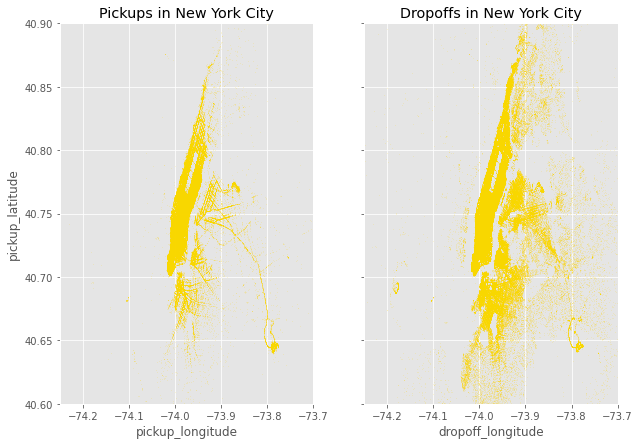

In [37]:
#Plotting the pickup and dropoff locations of New York
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))

#Plotting pickup map in  NYC
Pickups=train.plot(kind='scatter',x='pickup_longitude',y='pickup_latitude',s=.02,alpha=.6,xlim=(long_min,long_max),ylim=(lat_min,lat_max),color='gold',subplots=True,ax=ax1)
ax1.set_title('Pickups in New York City')
# ax1.set_axis_bgcolor('black') # black as a background color
pass

#Plotting pickup map in  NYC
Dropoffs=train.plot(kind='scatter',x='dropoff_longitude',y='dropoff_latitude',s=.02,alpha=.6,xlim=(long_min,long_max),ylim=(lat_min,lat_max),color='gold',subplots=True,ax=ax2)
ax2.set_title('Dropoffs in New York City')
# ax2.set_axis_bgcolor('black') # black as a background color
pass

fig.tight_layout()

Pickups are almost concentrated in Manhatten and dropoffs across the NYC.
This approximately could explain the reason why Vendor 2 pickups were greater than Vendor 1. May be Vendor 2 was operating mostly in the Manhatten region.

Analyzing NYC Map in 4 shifts:

> Indented block


Shift 1 - 7AM to 11 AM
Shift 2 - 11AM to 5PM
Shift 3 - 5PM to 11PM
Shift 4 - 11PM to 7AM

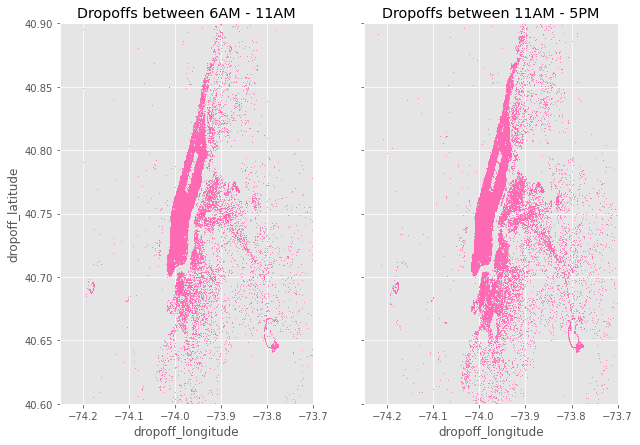

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))

#Shift 1
Mtime=train[(train['hh_dropoff']>=7) & (train['hh_dropoff']<11)]
Mtime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.2,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax1)
ax1.set_title('Dropoffs between 6AM - 11AM')
# ax1.set_axis_bgcolor('black')
pass

#Shift 2 
Atime=train[(train['hh_dropoff']>=11) & (train['hh_dropoff']<17)]
Atime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.2,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax2)
ax2.set_title('Dropoffs between 11AM - 5PM')
# ax2.set_axis_bgcolor('black')
pass

fig.tight_layout()

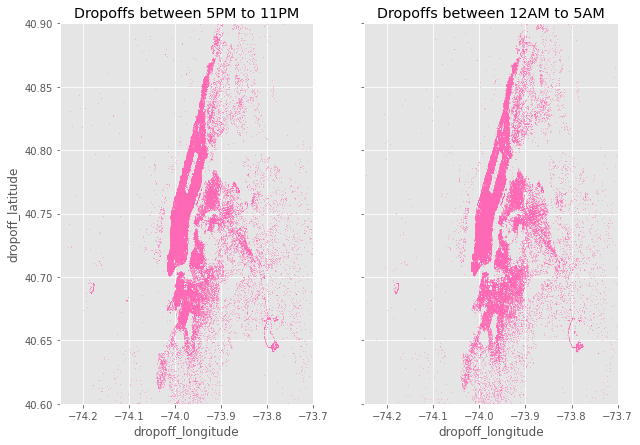

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))

#Shift 3
Etime=train[(train['hh_dropoff']>=17) & (train['hh_dropoff']<23)]
Etime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.05,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax1)
ax1.set_title('Dropoffs between 5PM to 11PM')
# ax1.set_axis_bgcolor('black')
pass

#Shift 4 : Night Time - 0AM to 5AM
Ntime=train[(train['hh_dropoff']>=0) & (train['hh_dropoff']<7)]
Ntime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.05,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax2)
ax2.set_title('Dropoffs between 12AM to 5AM')
# ax2.set_axis_bgcolor('black')
pass

**Modification** 

Creating **Seasons** -

S1 = Month of January and February as they are the cold months
S2=Month of March, April and May less cold 
S3=Month of June as a little warmer month

In [40]:
#For the train dataset
train['s1']= train['mm_pickup']<=2
train['s2']= train['mm_pickup'].between(3,5)
train['s3']= train['mm_pickup']>=6

#For the test dataset
test['s1']= test['mm_pickup']<=2
test['s2']= test['mm_pickup'].between(3,5)
test['s3']= test['mm_pickup']>=6

**Model and Predict**

Importing **scikit-learn** packages

In [41]:
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [42]:
print(train.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'mm_pickup', 'mm_dropoff', 'dow_pickup', 'dow_dropoff',
       'yday', 'hh_pickup', 'hh_dropoff', 'distance_km', 'log_distance',
       'speed', 's1', 's2', 's3'],
      dtype='object')


In [43]:
print(test.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'mm_pickup', 'dow_pickup',
       'yday', 'hh_pickup', 'distance_km', 's1', 's2', 's3'],
      dtype='object')


Checking significant variables through **ANOVA** table

In [44]:
x=train[['distance_km','pickup_longitude','passenger_count','vendor_id','pickup_latitude','yday','dropoff_longitude','dropoff_latitude','dow_pickup','hh_pickup','mm_pickup']]
Y=train['trip_duration']
x=sm.add_constant(x)
model=sm.OLS(Y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 1.383e+05
Date:                Fri, 16 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:25:06   Log-Likelihood:            -8.9888e+06
No. Observations:             1222114   AIC:                         1.798e+07
Df Residuals:                 1222102   BIC:                         1.798e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.035e+05   1382.718    -74.858      0.000   -1.06e+05   -1.01e+05
distance_km         106.3137      0.108    987.108      0.000     106.103     106.525
pickup_longitude   -538.3020     10.683    -50.390      0.000    -559.240    -517.364
passenger_count       2.7237      0.272     10.032      0.000       2.192       3.256
vendor_id            -0.8882      0.716     -1.241      0.215      -2.291       0.515
pickup_latitude    1200.7563     13.971     85.949      0.000    1173.374    1228.138
yday                  0.0098      0.005      2.058      0.040       0.000       0.019
dropoff_longitude  -794.6743     10.819    -73.452      0.000    -815.879    -773.470
dropoff_latitude  -1070.5333     11.816    -90.599      0.000   -1093.692   -1047.374
dow_pickup          -12.1373      0.177    -68.465      0.000     -12.485     -11.790
hh_pickup             3.7298      0.054     68.843      0.000       3.624       3.836
mm_pickup            17.4253      0.234     74.358      0.000      16.966      17.885
==============================================================================
Omnibus:                   331673.305   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1241328.891
Skew:                           1.326   Prob(JB):                         0.00
Kurtosis:                       7.164   Cond. No.                     4.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We won't be including those variables whose p-values are greater than 0.5 as they are not statistically significant or in other terms they aren't capable of making an impact on dependent variable.

In [45]:
features=['distance_km','pickup_longitude','pickup_latitude','yday','dropoff_longitude','dropoff_latitude','dow_pickup','hh_pickup'] 
X_train=train[features]
y_train=train['trip_duration']
feature_cols=['distance_km','pickup_longitude','pickup_latitude','yday','dropoff_longitude','dropoff_latitude','dow_pickup','hh_pickup'] 
X_test=test[feature_cols]

In [46]:
# Task: Feature Scaling

While the feature selection for the model has been done. There's one step remaining which is feature scaling. In order to overcome the issue of large MSE values we need to normalize the values in each column. Refer to [this](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html) article to learn more about feature scaling. 


In [47]:
X_Train,X_test,Y_train,Y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [48]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
scores = cross_val_score(linreg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print (scores)

[-145478.92872301 -145228.16680895 -143652.78338549 -144041.09685527
 -143860.94406364 -141470.92308561 -143413.44716107 -143730.93566008
 -142939.72184606 -145287.10239242]
